# Grid by number simulation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import segmenteverygrain.interactions as si
import shapely
from tqdm import tqdm
%matplotlib inline

2025-04-16 20:01:57.961531: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744858917.973723  118638 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744858917.977215  118638 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-16 20:01:57.989668: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load data

Images can be loaded in most common formats.

Grain information is saved as a .geojson file generated by this or other scripts.

In [2]:
# Load image
fn = 'examples/torrey_pines.jpg'
image = si.load_image(fn)
img_y, img_x = image.shape[:2]

In [3]:
# Load grains
fn = './examples/auto/torrey_pines_grains.geojson'
grains = si.load_grains(fn, image=image)

### Grid count

Generate a grid with a given spacing between points, then find the grain that contains each point (if any).

In [4]:
# Define grid spacing (in pixels)
spacing_m = 0.05                    # m
px_per_m = 3390.                    # px/m
spacing_px = px_per_m * spacing_m   # px

# Find and measure grains according to grid
points, xs, ys = si.make_grid(image, spacing_px)
grains, points_found = si.filter_grains_by_points(grains, points)
for g in grains:
    g.measure()

### Results

First, visualize the generated grid and detected grains:

100%|██████████| 33/33 [00:00<00:00, 1003.60it/s]


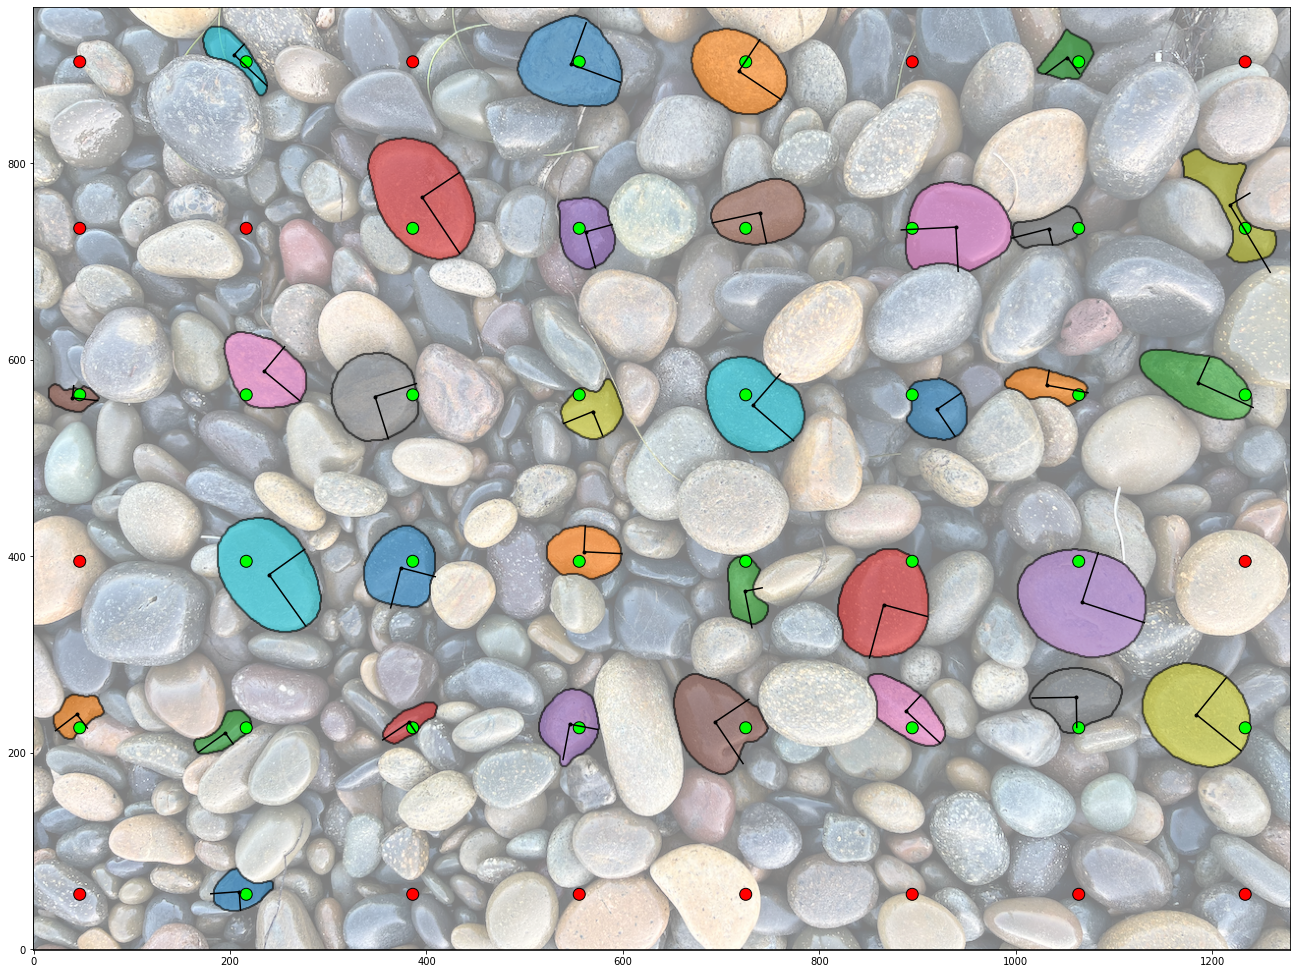

In [5]:
# Get GrainPlot as a static image
dpi = 72
plot = si.GrainPlot(grains, image, 
    figsize = (img_x / dpi, img_y / dpi), 
    dpi = dpi,
    px_per_m = px_per_m,
    image_alpha = 0.5)
plot_image = np.asarray(plot.canvas.buffer_rgba(), dtype=np.uint8)
plt.close(plot.fig)

# Make new plot using static GrainPlot image as background
fig = plt.figure(
    figsize=(img_x/dpi, img_y/dpi),
    dpi=dpi)
ax = fig.add_subplot()
ax.imshow(plot_image, aspect='equal', origin='lower')
ax.autoscale(enable=False)

# Plot grain axes
for grain in tqdm(grains):
    grain.draw_axes(ax, plot.scale)

# Plot grid points
ax.scatter(xs, ys,
    s=min(plot_image[:2].shape) * dpi,
    c=['lime' if p else 'red' for p in points_found],
    edgecolors='black')
fig.tight_layout(pad=0)

Then, the following results are then saved to the location specified in `out_fn`:
- Grain shapes, for use elsewhere (geojson)
- Image with grid points displayed and counted grains highlighted (jpg)
- Summary data, presenting measurements for each detected grain (csv)
- Summary histogram, representing major/minor axes of detected grains (jpg)

In [6]:
# Save results
out_fn = 'examples/grid_count/torrey_pines'
# Grain shapes
si.save_grains(out_fn + '_grains.geojson', grains)
# Grain image
fig.savefig(out_fn + '_grains.jpg', bbox_inches='tight', pad_inches=0)
# Summary data
summary = si.save_summary(out_fn + '_summary.csv', grains, px_per_m=px_per_m)
# Summary histogram
si.save_histogram(out_fn + '_summary.jpg', summary=summary)